In [35]:
import numpy as np
import skimage
import skimage.data
import skimage.io
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from matplotlib.patches import Patch
import ipywidgets as ipw
import sklearn.model_selection
import sklearn.neighbors
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, f1_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Functions

In [2]:
def resize_and_save_folder(input_dir, output_dir, scale=1.0):
    os.makedirs(output_dir, exist_ok=True)

    files = sorted([
        f for f in os.listdir(input_dir)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])

    for f in files:
        in_path = os.path.join(input_dir, f)
        out_path = os.path.join(output_dir, f)

        with Image.open(in_path) as img:
            new_size = (int(img.width * scale), int(img.height * scale))
            img_resized = img.resize(new_size, Image.LANCZOS)
            img_resized.save(out_path)

    print(f"Saved {len(files)} images in: {output_dir}")
    

def resize_and_save_all(paths, out_root="dataset/resized", scale=1.0):
    
    if os.path.exists(out_root):
        print(f"{out_root} already exists. Skipping resizing.")
        return
    
    out_paths = {
        key: os.path.join(out_root, key)
        for key in ["orig", "label", "rgb"]
    }

    resize_and_save_folder(paths["orig"],  out_paths["orig"],  scale)
    resize_and_save_folder(paths["label"], out_paths["label"], scale)
    resize_and_save_folder(paths["rgb"],   out_paths["rgb"],   scale)

def load_resized_images(orig_dir, label_dir, rgb_dir):
    orig_image = []
    label_image = []
    rgb_image = []

    # ORIG
    orig_files = sorted([f for f in os.listdir(orig_dir) if f.endswith((".jpg",".png",".jpeg"))])
    for f in orig_files:
        orig_image.append(Image.open(os.path.join(orig_dir, f)))

    # LABEL
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith((".jpg",".png",".jpeg"))])
    for f in label_files:
        label_image.append(Image.open(os.path.join(label_dir, f)))

    # RGB
    rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith((".jpg",".png",".jpeg"))])
    for f in rgb_files:
        rgb_image.append(Image.open(os.path.join(rgb_dir, f)))

    return orig_image, label_image, rgb_image


In [3]:
def pick_random_centers(mask, size=100, ignore=0):
    mask_ignored = mask.copy()
    mask_ignored[:ignore,:]=False
    mask_ignored[-ignore:,:]=False
    mask_ignored[:,:ignore]=False
    mask_ignored[:,-ignore:]=False
    rs, cs = np.where(mask_ignored)
    if len(rs) < 3:
        return None,None
    ix = np.random.randint(len(rs), size=size)
    return rs[ix], cs[ix]

In [72]:
def plot_confusion_matrix(y_true, y_pred, labels=['True', 'False'], report=False, title="Confusion Matrix"):
    if report:
        print(classification_report(y_true, y_pred, digits=4))
    
    print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted') * 100:.2f}%")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 1. Read Dataset

In [5]:
base = "dataset"
paths = {
    "label": os.path.join(base, "label_images_semantic"),
    "orig": os.path.join(base, "original_images"),
    "rgb":  os.path.join(base, "RGB_color_image_masks")
}

orig_files = sorted([f for f in os.listdir(paths["orig"]) if f.endswith(".jpg")])
df = pd.read_csv(os.path.join(base, "class_dict_seg.csv"))
color_items = [(row["name"], (int(row["r"]), int(row["g"]), int(row["b"]))) for i, row in df.iterrows()]


In [6]:
n_total = len(orig_files)

### 1.1. Index checks 

In [7]:
for name, path in paths.items():
    count = len([f for f in os.listdir(path) if f.lower().endswith((".jpg",".png"))])
    print(f"{name} images: {count}")

label images: 400
orig images: 400
rgb images: 400


In [8]:
indices = [int(os.path.splitext(f)[0]) for f in orig_files]

print("Lowest index:", min(indices))
print("Highest index:", max(indices))

Lowest index: 0
Highest index: 399


In [9]:
expected = set(range(min(indices), max(indices)+1))
actual = set(indices)

missing = sorted(list(expected - actual))

if missing:
    print("Missing indices:", missing)
else:
    print("No missing indices, numbering is continuous.")

No missing indices, numbering is continuous.


In [10]:
print(f"Da eseguire solo una volta per mettere a posto il nome delle immagini siccome alcune sono mancanti")

# # Rename all files with a "t_" prefix to avoid name conflicts
# for new_idx, f_jpg in enumerate(orig_files):
#     base_name = os.path.splitext(f_jpg)[0]
#     f_png = base_name + ".png"

#     temp_name_jpg = f"t_{new_idx:03d}.jpg"
#     temp_name_png = f"t_{new_idx:03d}.png"

#     # Rename original image
#     os.rename(os.path.join(paths["orig"], f_jpg),
#               os.path.join(paths["orig"], temp_name_jpg))
#     # Rename label image
#     os.rename(os.path.join(paths["label"], f_png),
#               os.path.join(paths["label"], temp_name_png))
#     # Rename RGB mask
#     os.rename(os.path.join(paths["rgb"], f_png),
#               os.path.join(paths["rgb"], temp_name_png))

# # Now remove the "t_" prefix to set new numbering
# for f in os.listdir(paths["orig"]):
#     if f.startswith("t_"):
#         new_name = f.replace("t_", "")
#         os.rename(os.path.join(paths["orig"], f),
#                   os.path.join(paths["orig"], new_name))

# for f in os.listdir(paths["label"]):
#     if f.startswith("t_"):
#         new_name = f.replace("t_", "")
#         os.rename(os.path.join(paths["label"], f),
#                   os.path.join(paths["label"], new_name))

# for f in os.listdir(paths["rgb"]):
#     if f.startswith("t_"):
#         new_name = f.replace("t_", "")
#         os.rename(os.path.join(paths["rgb"], f),
#                   os.path.join(paths["rgb"], new_name))

Da eseguire solo una volta per mettere a posto il nome delle immagini siccome alcune sono mancanti


### 1.2. Manage dataset

In [11]:
orig_files = sorted([f for f in os.listdir(paths["orig"]) if f.endswith(".jpg")])
label_files = sorted([f for f in os.listdir(paths["label"]) if f.endswith(".png")])
RGB_files = sorted([f for f in os.listdir(paths["rgb"]) if f.endswith(".png")])
scale = 0.25

In [12]:
resize_and_save_all(paths, out_root="dataset/resized", scale=scale)

dataset/resized already exists. Skipping resizing.


In [13]:
orig_image, label_image, rgb_image = load_resized_images(
    "dataset/resized/orig",
    "dataset/resized/label",
    "dataset/resized/rgb"
)

### 1.3. Image visualizations

- Visualize some images and corresponding segmentation masks.

In [14]:
@ipw.interact(index=ipw.IntSlider(min=0,max=len(orig_image)-1))

def plot_images(index):
    plt.figure(figsize=(9,3))
    plt.suptitle(f"Index {index}")
    
    plt.subplot(1,3,1)
    plt.imshow(orig_image[index])
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(label_image[index])
    plt.title("Label")
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(rgb_image[index])
    plt.title("RGB Mask")
    plt.axis('off')
    
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

In [ ]:
@ipw.interact(index=ipw.IntSlider(min=0,max=len(orig_image)-1))

def plot_images_labels(index):
    
    img_rgb = rgb_image[index]
    arr = np.array(img_rgb).reshape(-1,3)
    unique_colors = {tuple(c) for c in arr}

    present = [(name,(r,g,b)) for name,(r,g,b) in color_items if (r,g,b) in unique_colors]

    plt.figure(figsize=(11,4))
    plt.suptitle(f"Index {index}")
    plt.subplot(1,2,1)
    plt.imshow(orig_image[index])
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(rgb_image[index])
    plt.title("RGB Mask")
    plt.axis('off')

    handles = [Patch(facecolor=(r/255,g/255,b/255), label=name) for name,(r,g,b) in present]
    plt.legend(handles=handles, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

## 3. Binary segmentation

### 3.1. Create binary image

In [16]:
vegetation = np.array([107,142,35])
grass = np.array([0,102,0])
tree = np.array([51,51,0])

In [17]:
scale = 0.25  
n_points = 3
size = 16
# out_dir = os.path.join(base, "binary_veg")
# os.makedirs(out_dir, exist_ok=True)

In [18]:
binary_im = []

for image in rgb_image:
        
    arr = np.array(image)

    # binarization 1 for vegetable and 0 otherwise
    mask = (np.all(arr == vegetation, axis=-1) | np.all(arr == grass, axis=-1) | np.all(arr == tree, axis=-1))
    mask_img = mask.astype(np.uint8) * 255

    binary_im.append(mask_img)


### 3.2. Create patches

In [19]:
patches = []
labels = []
patch_img_idx = []
coords_dict = {}  

for i in range(len(binary_im)):
    orig = np.array(orig_image[i])
    binary = binary_im[i]    
      
    rs_veg, cs_veg = pick_random_centers(binary, size=n_points, ignore=size)
    if rs_veg is None:
        rs_veg, cs_veg = np.array([]), np.array([])
    
    rs_nonveg, cs_nonveg = pick_random_centers(~binary, size=n_points, ignore=size)
    if rs_nonveg is None:
        rs_nonveg, cs_nonveg = np.array([]), np.array([])
    
    coords_dict[i] = {
        "veg": (rs_veg, cs_veg),
        "nonveg": (rs_nonveg, cs_nonveg)
    }

    for r,c in zip(rs_veg, cs_veg):
        patches.append(orig[r-size:r+size, c-size:c+size, :])
        labels.append(binary[r,c])
        patch_img_idx.append(i)

    for r,c in zip(rs_nonveg, cs_nonveg):
        patches.append(orig[r-size:r+size, c-size:c+size, :])
        labels.append(binary[r,c])
        patch_img_idx.append(i)


In [27]:
@ipw.interact(index=ipw.IntSlider(min=0, max=len(orig_image)-1))
def plot_patches(index):
    rs_veg, cs_veg = coords_dict[index]["veg"]
    rs_nonveg, cs_nonveg = coords_dict[index]["nonveg"]

    patches_i = [p for p, idx in zip(patches, patch_img_idx) if idx == index]
    n_veg = len(rs_veg)
    n_nonveg = len(rs_nonveg)

    fig = plt.figure(figsize=(12,5))
    
    # Original Image
    ax0 = fig.add_subplot(1,2,1)
    ax0.imshow(orig_image[index])
    ax0.scatter(cs_veg, rs_veg, c='red', label='Vegetation', s=10)
    ax0.scatter(cs_nonveg, rs_nonveg, c='white', label='Non Vegetation', s=10)
    ax0.set_title(f"Original {index}")
    ax0.legend()

    # Vegetation
    for i, patch in enumerate(patches_i[:n_veg]):
        ax = fig.add_subplot(2, max(n_veg,n_nonveg), i+1,position=[0.55 + i*0.12, 0.52, 0.12, 0.25])
        ax.imshow(patch)
        ax.axis('off')
        if i == 0:
            ax.set_title("Vegetation")

    # Non-Vegetation
    for i, patch in enumerate(patches_i[n_veg:n_veg+n_nonveg]):
        ax = fig.add_subplot(2, max(n_veg,n_nonveg), i+1,position=[0.55 + i*0.12, 0.20, 0.12, 0.25])
        ax.imshow(patch)
        ax.axis('off')
        if i == 0:
            ax.set_title("Non Vegetation")

    plt.show()


interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

### 3.3. KNN-classifier

In [74]:
patches_array = np.array(patches)

N_patches = patches_array.shape[0]
feature_vectors = patches_array.reshape(N_patches, -1)

labels_array = np.array(labels, dtype=np.uint8)

print(f"Shape feautures: {feature_vectors.shape}")
print(f"Shape labels: {labels_array.shape}")

Shape feautures: (2379, 3072)
Shape labels: (2379,)


In [75]:
X_train_val, X_test, y_train_val, y_test = sklearn.model_selection.train_test_split(
    feature_vectors, 
    labels_array, 
    test_size=0.3,  
    random_state=42, 
    stratify=labels_array 
)


X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X_train_val, 
    y_train_val, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_train_val 
)

In [76]:
print(f"Training X: {X_train.shape}, y: {y_train.shape}")
print(f"Validation X: {X_val.shape}, y: {y_val.shape}")
print(f"Test X: {X_test.shape}, y: {y_test.shape}")

Training X: (1165, 3072), y: (1165,)
Validation X: (500, 3072), y: (500,)
Test X: (714, 3072), y: (714,)


In [77]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [78]:
y_pred = knn.predict(X_test)

              precision    recall  f1-score   support

           0     0.7523    0.9220    0.8285       359
         255     0.8978    0.6930    0.7822       355

    accuracy                         0.8081       714
   macro avg     0.8250    0.8075    0.8054       714
weighted avg     0.8246    0.8081    0.8055       714

F1 Score (weighted): 80.55%


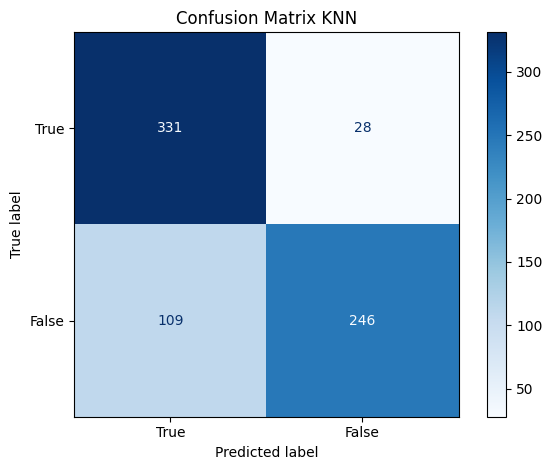

In [79]:
plot_confusion_matrix(y_test, y_pred, report=True, title="Confusion Matrix KNN")

### 3.4 Convolutional NN

In [80]:
X_train_val, X_test, y_train_val, y_test = sklearn.model_selection.train_test_split(
    patches_array, labels_array, test_size=0.3, random_state=42, stratify=labels_array 
)

X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42, stratify=y_train_val 
)

In [81]:
print(f"Training X: {X_train.shape}, y: {y_train.shape}")
print(f"Validation X: {X_val.shape}, y: {y_val.shape}")
print(f"Test X: {X_test.shape}, y: {y_test.shape}")

Training X: (1165, 32, 32, 3), y: (1165,)
Validation X: (500, 32, 32, 3), y: (500,)
Test X: (714, 32, 32, 3), y: (714,)


In [82]:
def build_model(input_shape, num_classes):
    m = Sequential()
    
    m.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    m.add(Activation('relu'))
    m.add(Conv2D(32, (3,3)))
    m.add(Activation('relu'))
    m.add(MaxPooling2D((2,2)))
    m.add(Dropout(0.25))

    m.add(Conv2D(64, (3,3), padding='same'))
    m.add(Activation('relu'))
    m.add(Conv2D(64, (3,3)))
    m.add(Activation('relu'))
    m.add(MaxPooling2D((2,2)))
    m.add(Dropout(0.25))

    m.add(Flatten())
    m.add(Dense(512))
    m.add(Activation('relu'))
    m.add(Dropout(0.5))
    m.add(Dense(num_classes))
    
    if num_classes == 1:
        m.add(Activation('sigmoid'))
    else:
        m.add(Activation('softmax'))
    
    return m

In [83]:
X_train_norm = X_train.astype(float) / 255
X_val_norm = X_val.astype(float) / 255
X_test_norm = X_test.astype(float) / 255

y_train_bin = y_train / 255 
y_val_bin = y_val / 255
y_test_bin = y_test / 255

In [84]:
model_cnn = build_model(input_shape=X_train.shape[1:], num_classes=1)
model_cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


c:\Users\Sergio\.virtualenvs\Computer_Vision_Project-48qI0K-4\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
history = model_cnn.fit(X_train_norm, y_train_bin, epochs=30, 
          batch_size=32,
          validation_data=(X_val_norm, y_val_bin),
          verbose=1)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7725 - loss: 0.4848 - val_accuracy: 0.8380 - val_loss: 0.3872
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8489 - loss: 0.3584 - val_accuracy: 0.8420 - val_loss: 0.3476
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8678 - loss: 0.3246 - val_accuracy: 0.8460 - val_loss: 0.3347
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8678 - loss: 0.2988 - val_accuracy: 0.8680 - val_loss: 0.2942
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8455 - loss: 0.3342 - val_accuracy: 0.8620 - val_loss: 0.3082
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8678 - loss: 0.3095 - val_accuracy: 0.8520 - val_loss: 0.3420
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8506 - loss: 0.3481 - val_accuracy: 0.8600 - val_loss: 0.3144
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8592 - loss: 0.3028 - val_accuracy: 0.8680 - v

In [86]:
y_pred_proba = model_cnn.predict(X_test_norm, verbose=0)
y_pred_bin = (y_pred_proba > 0.5).astype(int)
y_true_bin = y_test_bin.astype(int)

F1 Score (weighted): 85.49%


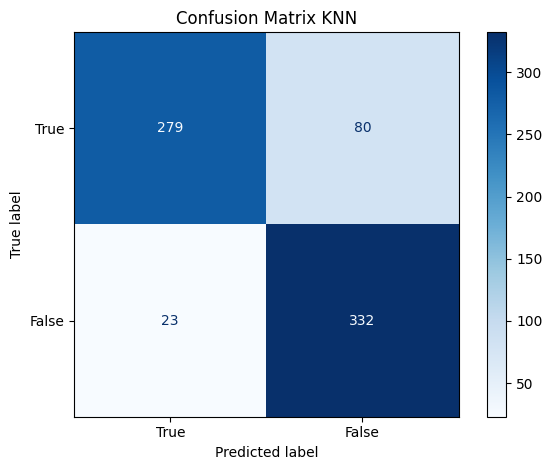

In [87]:
plot_confusion_matrix(y_true_bin, y_pred_bin, report=False, title="Confusion Matrix KNN")